# Multi-Class Neural Network (3 Hidden Layers, Sigmoid Hidden + Softmax Output)


## 1. Imports and Dataset Generation

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(0)

# ----- Synthetic dataset with 5 classes -----
num_classes = 5
samples_per_class = 200
input_dim = 2

X_list = []
y_list = []

# Choose 5 different centers in 2D space for 5 Gaussian blobs
centers = [(-4, -4), (-4, 4), (4, -4), (4, 4), (0, 0)]

for class_ix, center in enumerate(centers):
    # Generate 'samples_per_class' points around the class center
    x = np.random.randn(samples_per_class, input_dim) + np.array(center)
    y = np.full((samples_per_class,), class_ix, dtype=int)
    X_list.append(x)
    y_list.append(y)


X = np.vstack(X_list)
y = np.concatenate(y_list)

num_samples = X.shape[0]

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Number of classes:", num_classes)


X shape: (1000, 2)
y shape: (1000,)
Number of classes: 5


### One-Hot Encoding and Train/Test Split

In [29]:
# ----- One-hot encode the labels -----
# y is of shape (N,), values in {0, 1, 2, 3, 4}
Y = np.zeros((num_samples, num_classes))
Y[np.arange(num_samples), y] = 1

print("Y shape (one-hot):", Y.shape)

# ----- Train / Test split (80% train, 20% test) -----
indices = np.arange(num_samples)
np.random.shuffle(indices)

train_size = int(0.8 * num_samples)
train_idx = indices[:train_size]
test_idx = indices[train_size:]

X_train = X[train_idx]
Y_train = Y[train_idx]
y_train = y[train_idx]

X_test = X[test_idx]
Y_test = Y[test_idx]
y_test = y[test_idx]

print("Train set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])


Y shape (one-hot): (1000, 5)
Train set size: 800
Test set size: 200


### Visualizing the Training Data

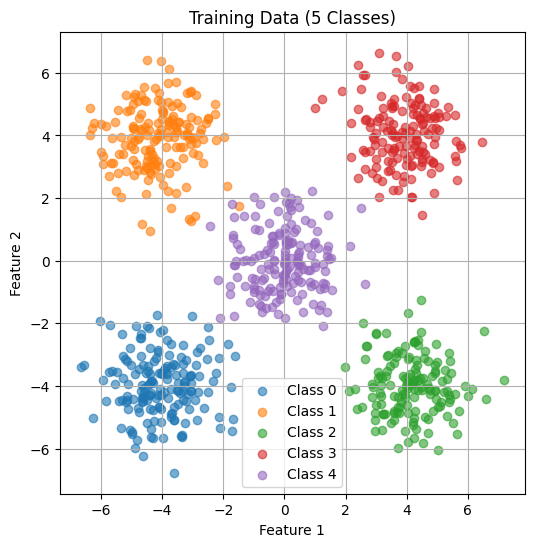

In [30]:
plt.figure(figsize=(6, 6))
for c in range(num_classes):
    class_points = X_train[y_train == c]
    plt.scatter(class_points[:, 0], class_points[:, 1], label=f"Class {c}", alpha=0.6)
plt.title("Training Data (5 Classes)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()


## 2. Three Hidden Layer Neural Network Implementation

In [31]:
class NeuralNetwork:
    # Three-hidden-layer fully connected neural network for multi-class classification.
    # Hidden layers: sigmoid
    # Output layer: softmax
    # Loss: cross-entropy.
    def __init__(self, input_dim, h1, h2, h3, output_dim, learning_rate=0.05):
        self.input_dim = input_dim
        self.h1 = h1
        self.h2 = h2
        self.h3 = h3
        self.output_dim = output_dim
        self.learning_rate = learning_rate

        # Weight initialization: small random values
        self.W1 = np.random.randn(input_dim, h1) * 0.1
        self.b1 = np.zeros((1, h1))

        self.W2 = np.random.randn(h1, h2) * 0.1
        self.b2 = np.zeros((1, h2))

        self.W3 = np.random.randn(h2, h3) * 0.1
        self.b3 = np.zeros((1, h3))

        # Last layer (h3 -> output_dim)
        self.W4 = np.random.randn(h3, output_dim) * 0.1
        self.b4 = np.zeros((1, output_dim))

    # ---------- Activation functions ----------
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def sigmoid_derivative(self, x):

        s = self.sigmoid(x)
        return s * (1 - s)

    def softmax(self, z):

        z_stable = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z_stable)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    # ---------- Forward propagation ----------
    def feed_forward(self, X):
        """Compute forward pass and store intermediate results."""
        self.z1 = X.dot(self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)

        self.z2 = self.a1.dot(self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)

        self.z3 = self.a2.dot(self.W3) + self.b3
        self.a3 = self.sigmoid(self.z3)

        self.z4 = self.a3.dot(self.W4) + self.b4
        self.probs = self.softmax(self.z4)

        return self.probs

    def compute_loss(self, Y_true, probs):
        """Cross-entropy loss for multi-class classification."""
        m = Y_true.shape[0]
        eps = 1e-15  # avoid log(0)
        clipped = np.clip(probs, eps, 1.0 - eps)
        log_likelihood = -np.sum(Y_true * np.log(clipped))
        loss = log_likelihood / m
        return loss

    # ---------- Backpropagation ----------
    def backprop(self, X, Y_true):
        """Perform one step of backpropagation and update weights."""
        m = X.shape[0]


        delta4 = (self.probs - Y_true) / m

        dW4 = self.a3.T.dot(delta4)
        db4 = np.sum(delta4, axis=0, keepdims=True)

        # Backprop into layer 3
        delta3 = delta4.dot(self.W4.T) * self.sigmoid_derivative(self.z3)
        dW3 = self.a2.T.dot(delta3)
        db3 = np.sum(delta3, axis=0, keepdims=True)

        # Backprop into layer 2
        delta2 = delta3.dot(self.W3.T) * self.sigmoid_derivative(self.z2)
        dW2 = self.a1.T.dot(delta2)
        db2 = np.sum(delta2, axis=0, keepdims=True)

        # Backprop into layer 1
        delta1 = delta2.dot(self.W2.T) * self.sigmoid_derivative(self.z1)
        dW1 = X.T.dot(delta1)
        db1 = np.sum(delta1, axis=0, keepdims=True)

        lr = self.learning_rate
        self.W4 -= lr * dW4
        self.b4 -= lr * db4

        self.W3 -= lr * dW3
        self.b3 -= lr * db3

        self.W2 -= lr * dW2
        self.b2 -= lr * db2

        self.W1 -= lr * dW1
        self.b1 -= lr * db1

    def predict_proba(self, X):
        """Return class probabilities for inputs X."""
        return self.feed_forward(X)

    def predict(self, X):
        """Return class indices (0..num_classes-1) for inputs X."""
        probs = self.feed_forward(X)
        return np.argmax(probs, axis=1)


## 3. Training the Network

In [32]:
# Hyperparameters
input_dim = X_train.shape[1]
hidden1 = 64
hidden2 = 64
hidden3 = 32
output_dim = num_classes
learning_rate = 0.1
epochs = 1000

nn = NeuralNetwork(input_dim, hidden1, hidden2, hidden3, output_dim, learning_rate)

train_loss_history = []
test_loss_history = []
train_acc_history = []
test_acc_history = []

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

for epoch in range(epochs):
    # Forward on training data
    probs_train = nn.feed_forward(X_train)
    loss_train = nn.compute_loss(Y_train, probs_train)

    # Backprop + update
    nn.backprop(X_train, Y_train)

    # Evaluate on test data
    probs_test = nn.predict_proba(X_test)
    loss_test = nn.compute_loss(Y_test, probs_test)

    # Compute accuracy
    y_train_pred = np.argmax(probs_train, axis=1)
    y_test_pred = np.argmax(probs_test, axis=1)

    acc_train = accuracy(y_train, y_train_pred)
    acc_test = accuracy(y_test, y_test_pred)

    train_loss_history.append(loss_train)
    test_loss_history.append(loss_test)
    train_acc_history.append(acc_train)
    test_acc_history.append(acc_test)

    # Print progress occasionally
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train loss: {loss_train:.4f}, Train acc: {acc_train:.3f} - "
              f"Test loss: {loss_test:.4f}, Test acc: {acc_test:.3f}")


Epoch 100/1000 - Train loss: 1.6022, Train acc: 0.328 - Test loss: 1.6138, Test acc: 0.250
Epoch 200/1000 - Train loss: 1.5926, Train acc: 0.340 - Test loss: 1.6033, Test acc: 0.260
Epoch 300/1000 - Train loss: 1.5687, Train acc: 0.356 - Test loss: 1.5771, Test acc: 0.280
Epoch 400/1000 - Train loss: 1.4812, Train acc: 0.810 - Test loss: 1.4817, Test acc: 0.810
Epoch 500/1000 - Train loss: 1.1406, Train acc: 0.885 - Test loss: 1.1207, Test acc: 0.895
Epoch 600/1000 - Train loss: 0.7699, Train acc: 0.953 - Test loss: 0.7485, Test acc: 0.960
Epoch 700/1000 - Train loss: 0.4501, Train acc: 0.960 - Test loss: 0.4278, Test acc: 0.965
Epoch 800/1000 - Train loss: 0.2893, Train acc: 0.970 - Test loss: 0.2726, Test acc: 0.965
Epoch 900/1000 - Train loss: 0.2187, Train acc: 0.973 - Test loss: 0.2065, Test acc: 0.970
Epoch 1000/1000 - Train loss: 0.1782, Train acc: 0.973 - Test loss: 0.1693, Test acc: 0.975


### Training Curves: Loss and Accuracy

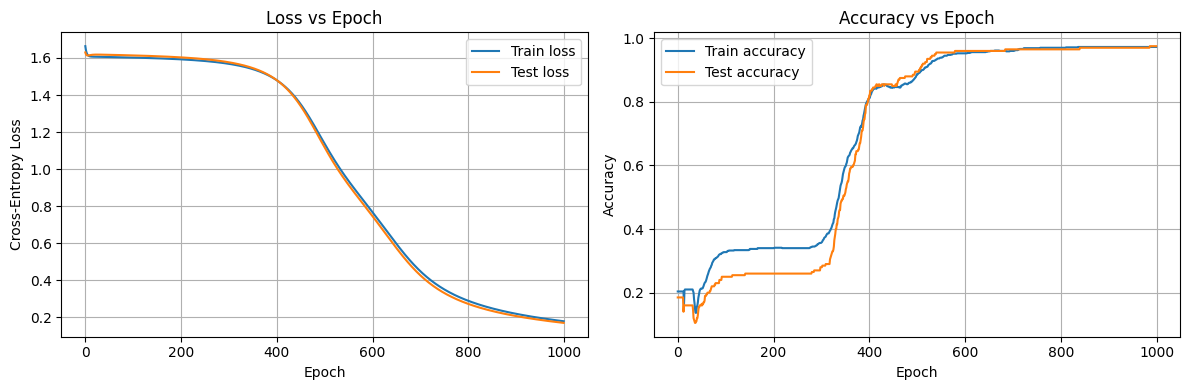

In [33]:
# Plot loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label="Train loss")
plt.plot(test_loss_history, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label="Train accuracy")
plt.plot(test_acc_history, label="Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [34]:
# Final predictions on test set
y_test_pred = nn.predict(X_test)

# ----- Confusion Matrix -----
confusion = np.zeros((num_classes, num_classes), dtype=int)
for true_label, pred_label in zip(y_test, y_test_pred):
    confusion[true_label, pred_label] += 1

print("Confusion Matrix (rows = true class, columns = predicted class):")
print(confusion)

# ----- Precision, Recall, F1 per class -----
precision_per_class = []
recall_per_class = []
f1_per_class = []

for c in range(num_classes):
    TP = confusion[c, c]
    FP = confusion[:, c].sum() - TP
    FN = confusion[c, :].sum() - TP

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    precision_per_class.append(precision)
    recall_per_class.append(recall)
    f1_per_class.append(f1)

# Overall accuracy
overall_accuracy = np.mean(y_test == y_test_pred)

print("\nPer-class metrics:")
for c in range(num_classes):
    print(f"Class {c}: "
          f"Precision={precision_per_class[c]:.3f}, "
          f"Recall={recall_per_class[c]:.3f}, "
          f"F1={f1_per_class[c]:.3f}")

print("\nOverall test accuracy:", overall_accuracy)

# Macro averages
macro_precision = np.mean(precision_per_class)
macro_recall = np.mean(recall_per_class)
macro_f1 = np.mean(f1_per_class)

print(f"\nMacro-averaged Precision: {macro_precision:.3f}")
print(f"Macro-averaged Recall:    {macro_recall:.3f}")
print(f"Macro-averaged F1-score:  {macro_f1:.3f}")


Confusion Matrix (rows = true class, columns = predicted class):
[[32  0  0  0  0]
 [ 0 37  0  0  0]
 [ 0  0 50  0  0]
 [ 0  0  0 49  0]
 [ 0  1  2  2 27]]

Per-class metrics:
Class 0: Precision=1.000, Recall=1.000, F1=1.000
Class 1: Precision=0.974, Recall=1.000, F1=0.987
Class 2: Precision=0.962, Recall=1.000, F1=0.980
Class 3: Precision=0.961, Recall=1.000, F1=0.980
Class 4: Precision=1.000, Recall=0.844, F1=0.915

Overall test accuracy: 0.975

Macro-averaged Precision: 0.979
Macro-averaged Recall:    0.969
Macro-averaged F1-score:  0.972


### Confusion Matrix Visualization

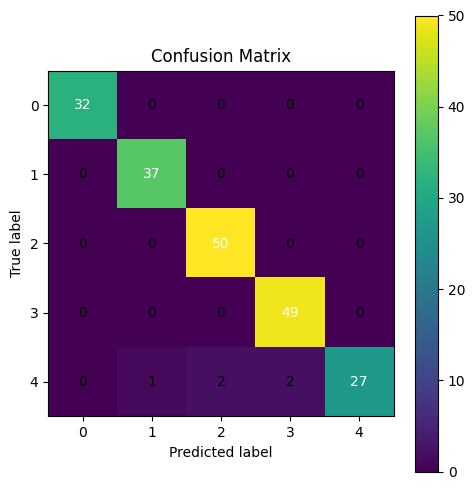

In [35]:
plt.figure(figsize=(5, 5))
plt.imshow(confusion, interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, [f"{i}" for i in range(num_classes)])
plt.yticks(tick_marks, [f"{i}" for i in range(num_classes)])
plt.xlabel("Predicted label")
plt.ylabel("True label")

# Annotate cells with counts
thresh = confusion.max() / 2.0
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, str(confusion[i, j]),
                 ha="center", va="center",
                 color="white" if confusion[i, j] > thresh else "black")
plt.tight_layout()
plt.show()


The original binary XOR-style neural network was extended into a full five-class classification model by replacing the single sigmoid output neuron with a five-neuron softmax layer and converting scalar labels into one-hot vectors. Three sigmoid-activated hidden layers were introduced to increase network depth, and the loss function was upgraded from MSE to multi-class cross-entropy. Backpropagation was redesigned to support four layers and the simplified softmax–cross-entropy gradient. A synthetic five-class dataset was generated, along with a train/test split and manually implemented evaluation metrics. Experiments showed that a small 20-20-20 architecture severely underfit, reaching only about 26% accuracy, whereas a larger 64-64-32 network achieved approximately 97.5% accuracy with excellent generalization.